### What is this notebook for? ###

The main purpose of this notebook is building dataset for training Liquidity's probability model.
Here we will enrich listings attributes with replies(within 7 days after creation) and javascript events(within 7 days after creation). 

JS events:

* 'reply_phone_show',
* 'reply_phone_call',
* 'reply_phone_sms',
* 'reply_phone_cancel',
* 'reply_message_sent',
* 'reply_message_click',
* 'reply_chat_sent'

**Prerequisities:**  

* csv file with listings attributes "otodom_Jun_Dec.csv". Can be obtained with sql code in the file `sql_queries/otodom.sql`, section 1.
* parsed attributes "ads_with_featuresOtodom.csv". Can be obtained with `ParamsOtodom.ipynb`
* replies "otodom_replies_Jun_Dec.csv". Can be obtained with sql code in the file `sql_queries/otodom.sql`, section 2.
* js events within 7 days "otodom_events_Jun_Dec.csv". Can be obtained with sql code in the file `sql_queries/otodom.sql`, section 3.
* [optional] views within 7 days "otodom_views_Jun_Dec.csv". Can be obtained with sql code in the file `sql_queries/otodom.sql`, section 4.

**Output:**
"ml_dataset_otodompl.tsv", separated with "\t"

In [1]:
import pandas as pd
import numpy as np
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ads = pd.read_csv('../data/Otodom/otodom_Jun_Dec.csv', header=None)

In [3]:
ads.shape

(1084786, 39)

In [4]:
ads.head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,48451134,16,302,371,159.0,213,1071655,NaN,2017-06-01 07:37:26.000000,2017-07-01 07:37:26.000000,...,0,0.0,530,0,NaN,20,0,14.527340,53.401570,1
1,48452110,7,102,197,117.0,26,232572,NaN,2017-06-01 09:21:45.000000,2017-06-08 09:40:50.000000,...,1,33.0,1600,48,NaN,10,50,20.932984,52.240101,1
2,48452396,16,201,364,NaN,2123,231932,NaN,2017-06-01 09:40:50.000000,2017-06-19 14:21:15.000000,...,4,190.0,785000,4131,NaN,8,52,14.876430,53.357060,1
3,48452430,7,102,197,39.0,26,757739,NaN,2017-06-01 09:42:34.000000,2017-06-14 23:13:04.000000,...,4,117.0,9500,81,NaN,33,47,21.033785,52.185715,1
4,48452522,7,102,197,41.0,26,757739,NaN,2017-06-01 09:45:47.000000,2017-06-14 23:13:20.000000,...,3,125.0,6200,49,NaN,23,47,21.051807,52.232840,1


In [5]:
ads.columns = ["ad_id", "region_id", "category_id", "subregion_id", "district_id", "city_id", "user_id", 
               "last_update_date", "created_at_first", "valid_to", "status", "title", "description",
               "params", "map_address", "private_business", 
"images_counter", "paidads_id_index", "paidads_id_payment", "paidads_valid_to", "was_paid_for_post",
"is_paid_for_post", "export_olx_to", "brand_program_id", "user_quality_score", "updated_at",
"street_name", "street_id", "panorama", "mysql_search_rooms_num", "mysql_search_m",
"mysql_search_price", "mysql_search_price_per_m", "movie", "ad_quality_score", "user_quality_score2",
"map_lon", "map_lat", "net_ad_counted"]

In [6]:
ads['ad_id'].nunique()

1084786

In [7]:
# Convert to datetime
ads['created_at_dt'] = ads.apply(
    lambda row: datetime.datetime.strptime(row['created_at_first'], '%Y-%m-%d %H:%M:%S.%f').date()
    if len(str(row['created_at_first'])) > 5 else 'false', axis=1) 

In [8]:
print(max(ads.created_at_dt))
print(min(ads.created_at_dt))

2017-12-31
2017-06-01


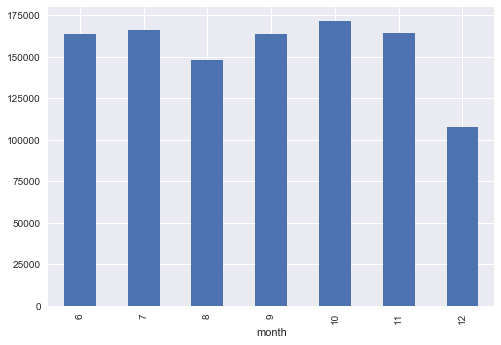

In [9]:
ads['month'] = ads['created_at_dt'].apply(lambda x: x.month)
ads.groupby(['month'])['ad_id'].nunique().plot(kind="bar")

**Add parsed parameters**

In [10]:
features = pd.read_csv("ads_with_featuresOtodom.csv")

/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4,17,30,34,53,59) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
features.head()

,ad_id,access_types,area_from,area_to,begin_date,build_year,building_floors_num,building_material,building_ownership,building_type,...,security_types,social_facilities,state,structure,terrain_area,type,use_types,vicinity_types,web,windows_type
0,48449224,NaN,NaN,NaN,NaN,NaN,5.0,brick,full_ownership,tenement,...,entryphone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,plastic
1,48449226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,48449228,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,800.0,NaN,NaN,0,NaN,NaN
3,48449230,hard_surfaced,NaN,NaN,NaN,2018.0,NaN,NaN,NaN,semi_detached,...,NaN,NaN,NaN,NaN,276.0,NaN,NaN,NaN,NaN,plastic
4,48449234,hard_surfaced,NaN,NaN,NaN,2018.0,NaN,NaN,NaN,semi_detached,...,NaN,NaN,NaN,NaN,276.0,NaN,NaN,NaN,NaN,plastic


In [12]:
ads = ads.merge(features, how="left", on="ad_id")

**Replies in 7 days**

In [13]:
answers = pd.read_csv('../data/Otodom/otodom_replies_Jun_Dec.csv', header=None)

In [14]:
answers.columns = ['ad_id', 'ad_created', 'reply_id', 'reply_parent_id', 'reply_sender_id', 'reply_posted_at']

In [15]:
answers.head()

,ad_id,ad_created,reply_id,reply_parent_id,reply_sender_id,reply_posted_at
0,48449710,2017-06-01 01:27:06.000000,9325896,0,1549013,2017-06-01 06:19:29.000000
1,48450552,2017-06-01 01:57:46.000000,9328400,0,2076768,2017-06-01 10:54:23.000000
2,48452534,2017-06-01 09:45:55.000000,9331486,0,2460442,2017-06-01 14:19:53.000000
3,48458338,2017-06-01 15:35:23.000000,9332726,0,999969,2017-06-01 15:57:58.000000
4,48449242,2017-06-01 00:05:51.000000,9333770,0,2659524,2017-06-01 17:08:09.000000


In [16]:
answers.shape

(1144050, 6)

In [17]:
answers['ad_created'] =  answers.apply(
    lambda row: datetime.datetime.strptime(row['ad_created'], '%Y-%m-%d %H:%M:%S.%f').date()
    if pd.notnull(row['ad_created']) else 'false', axis=1) 

In [18]:
answers['replied_at_dt'] =  answers.apply(
    lambda row: datetime.datetime.strptime(row['reply_posted_at'], '%Y-%m-%d %H:%M:%S.%f').date()
    if pd.notnull(row['reply_posted_at']) else 'false', axis=1) 

In [19]:
answers.head()

,ad_id,ad_created,reply_id,reply_parent_id,reply_sender_id,reply_posted_at,replied_at_dt
0,48449710,2017-06-01,9325896,0,1549013,2017-06-01 06:19:29.000000,2017-06-01
1,48450552,2017-06-01,9328400,0,2076768,2017-06-01 10:54:23.000000,2017-06-01
2,48452534,2017-06-01,9331486,0,2460442,2017-06-01 14:19:53.000000,2017-06-01
3,48458338,2017-06-01,9332726,0,999969,2017-06-01 15:57:58.000000,2017-06-01
4,48449242,2017-06-01,9333770,0,2659524,2017-06-01 17:08:09.000000,2017-06-01


**Count difference in days between creation date and reply date**

In [20]:
answers['replied_days_diff'] = answers.apply(lambda row: (row['replied_at_dt'] - row['ad_created']).days
                     if pd.notnull(row['replied_at_dt']) else None, axis=1)

Answers can be in thread. The first message in the thread have reply_parent_id = 0. We intrested only in that type of replies.

In [21]:
answers = answers[answers['reply_parent_id'] == 0]

We interested in 7 days window:

In [22]:
answers = answers[(answers['replied_days_diff'] < 7) & (answers['replied_days_diff'] >= 0)]

In [23]:
answers['replied_days_diff'].value_counts()

1    80089
0    67978
2    44851
3    33590
4    28024
5    24424
6    22201
Name: replied_days_diff, dtype: int64

In [24]:
answers.shape

(301157, 8)

**Count senders/unique senders amount within 7 days **

In [25]:
liquidity_leads = answers.groupby('ad_id')['reply_sender_id'].nunique()
all_leads = answers.groupby('ad_id')['reply_sender_id'].count()
replies = pd.concat([liquidity_leads, all_leads], axis=1)

In [26]:
replies.head()

,reply_sender_id,reply_sender_id
ad_id,,
48449224,1,1
48449242,1,2
48449276,2,4
48449298,1,2
48449348,1,2


In [27]:
replies['ad_id'] = replies.index

In [28]:
replies[replies['ad_id'] == 49845708]

,reply_sender_id,reply_sender_id,ad_id
ad_id,,,
49845708,2,4,49845708


In [29]:
replies.columns = ['unique_replies', 'total_replies', 'ad_id']

In [30]:
replies.head()

,unique_replies,total_replies,ad_id
ad_id,,,
48449224,1,1,48449224
48449242,1,2,48449242
48449276,2,4,48449276
48449298,1,2,48449298
48449348,1,2,48449348


#### Prepare js events

In [31]:
js_events = pd.read_csv("../data/Otodom/otodom_events_Jun_Dec.csv", header=None)

In [32]:
js_events.head()

,0,1,2
0,49434232,7,11
1,48514156,1,1
2,48537030,10,19
3,48530992,2,2
4,48565706,4,7


In [33]:
js_events.columns = ['ad_id', 'unique_js_events', 'total_events']

**Combine together replies and js events**

In [34]:
ads = ads.merge(replies, how='left', on='ad_id')

In [35]:
ads = ads.merge(js_events, how='left', on='ad_id')

In [36]:
ads[['unique_replies', 'total_replies', 'unique_js_events', 'total_events']] = ads[['unique_replies', 'total_replies','unique_js_events', 'total_events']].fillna(0)


In [37]:
ads['unique_senders'] = ads['unique_replies'] + ads['unique_js_events']

In [38]:
ads['total_leads'] = ads['total_replies'] + ads['total_events']

**Categories list**

* 101 - apartments to buy
* 102 - apartments for rent
* 103 - apartments for vacations
* 201 - houses to buy
* 202 - houses for rent
* 203 - houses for vacations
* 302 - rooms for rent
* 401 - land to buy
* 402 - land for rent
* 501 - stores to buy
* 502 - stors for rent
* 601 - warehouses to buy
* 602 - warehosues for rent
* 701 - garages to buy
* 702 - garages for rent
* 801 - offices to buy
* 802 - offices for rent
* 901 - buildings to buy
* 902 - building for rent
* 1101 - farms and estates to buy
* 1102 - farms and estates for rent
* 1201 - goodwill to buy

**Category distribution**

In [39]:
ads['category_id'].value_counts()

101    549234
102    135932
201    129599
401    103807
502     80916
501     23440
602     22135
302     19462
202     13517
601      3396
402      1574
701       806
702       578
11        390
Name: category_id, dtype: int64

#### Liquidity definition ####

**Liquidity** - binary metric. Equal to 1 if listings obtained 3 or more contacts from unique persons within 7 days after creation. Let's calculate liquidity for Otodom:

In [40]:
sum(ads['unique_senders']  >= 3)/len(ads)

0.1429636813159462

**Transform image number to integer**

In [41]:
np.binary_repr(int(1.638300e+04))
print(np.binary_repr(int(1.638300e+04)))
print(len(np.binary_repr(int(1.638300e+04))))

11111111111111
14


In [42]:
def get_number_of_images(coded_number):
    if pd.isnull(coded_number):
        return 0
    binary_repr = np.binary_repr(int(coded_number))
    binary_repr  = binary_repr.replace('0', '')
    return len(binary_repr)


In [43]:
get_number_of_images(12)

2

In [44]:
test = get_number_of_images(1.638300e+04)
test

14

In [45]:
ads['n_images'] = ads['images_counter'].apply(lambda x: get_number_of_images(x))

In [46]:
ads['n_images'].value_counts(normalize=True).head(10)

5     0.080760
4     0.080664
8     0.080546
6     0.078863
7     0.074134
3     0.067667
10    0.064694
9     0.062364
1     0.056607
2     0.052185
Name: n_images, dtype: float64

In [47]:
ads.to_csv("ml_dataset_otodompl.tsv", sep="\t")

**[Optional] Add views**.

We expereminted with contacts per views metric (which is defined as number of unique contacts within days divided by unique views amount during that period). In our models we don't use this attributes.

In [48]:
views = pd.read_csv("../data/Otodom/otodom_views_Jun_Dec.csv", header=None)

In [49]:
views.head()

,0,1,2
0,49209054,46,46
1,48683106,2,2
2,51159400,179,419
3,48671746,16,18
4,49668171,457,580


In [50]:
views.columns = ['ad_id', 'unique_week_views', 'week_views']

In [51]:
ads = ads.merge(views, how='left', on='ad_id')

In [52]:
ads.head()

,ad_id,region_id,category_id,subregion_id,district_id,city_id,user_id,last_update_date,created_at_first,valid_to,...,windows_type,unique_replies,total_replies,unique_js_events,total_events,unique_senders,total_leads,n_images,unique_week_views,week_views
0,48451134,16,302,371,159.0,213,1071655,NaN,2017-06-01 07:37:26.000000,2017-07-01 07:37:26.000000,...,NaN,0.0,0.0,2.0,2.0,2.0,2.0,2,19.0,20.0
1,48452110,7,102,197,117.0,26,232572,NaN,2017-06-01 09:21:45.000000,2017-06-08 09:40:50.000000,...,NaN,0.0,0.0,1.0,1.0,1.0,1.0,6,64.0,70.0
2,48452396,16,201,364,NaN,2123,231932,NaN,2017-06-01 09:40:50.000000,2017-06-19 14:21:15.000000,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2,53.0,54.0
3,48452430,7,102,197,39.0,26,757739,NaN,2017-06-01 09:42:34.000000,2017-06-14 23:13:04.000000,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,7,2.0,2.0
4,48452522,7,102,197,41.0,26,757739,NaN,2017-06-01 09:45:47.000000,2017-06-14 23:13:20.000000,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,10,1.0,1.0


In [53]:
ads.to_csv("ml_dataset_otodompl.tsv", sep="\t")